<small><font color=gray>Notebook authors: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a>, <a href="https://www.hse.ru/en/org/persons/223985242/" target="_blank">Alexey Boldyrev</a>, <a href="https://www.hse.ru/en/staff/mekarpov" target="_blank">Maksim Karpov</a> ©2024</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>💎Diamonds</font>](https://www.kaggle.com/t/73a7efacaa4342bcbe58932e62743ed4)**. [**Instructions**](https://colab.research.google.com/drive/1owkYjuRGkx050LQnM3b3yTzd0Dr2XbeV) for running Colabs.

<small>**(Optional) CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes. We understand that sharing is optional and this decision will not affect our grade in any way. <font color=gray><i>(If ok with sharing your Colab for educational purposes, leave "X" in the check box.)</i></font></small>

In [1]:
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm

In [2]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals
os.environ['TF_DETERMINISTIC_OPS'] = '1'; os.environ['TF_CUDNN_DETERMINISTIC'] = '1'; # allows seeding RNG on GPU

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=2, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)
tDIR, sDIR = 'trainXY/', 'testY/'

CPU times: total: 188 ms
Wall time: 3.67 s


In [3]:
df = pd.read_csv('XY_diamonds.csv'); df

,carat,depth,table,x,y,z,cut,color,clarity,price
0,0.35,67.2,57.1,4.64,4.69,2.87,I,G,VS1,NaN
1,1.64,67.3,60.7,7.84,7.82,4.94,V,E,SI1,NaN
...,...,...,...,...,...,...,...,...,...,...
199998,0.48,68.7,53.0,4.47,4.45,2.72,I,G,IF,1474.0
199999,0.48,65.0,64.7,5.60,5.62,3.44,I,H,VS2,765.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   carat    200000 non-null  float64
 1   depth    200000 non-null  float64
 2   table    200000 non-null  float64
 3   x        200000 non-null  float64
 4   y        200000 non-null  float64
 5   z        200000 non-null  float64
 6   cut      200000 non-null  object 
 7   color    200000 non-null  object 
 8   clarity  200000 non-null  object 
 9   price    160000 non-null  float64
dtypes: float64(7), object(3)
memory usage: 15.3+ MB


In [5]:
vX = df.query('price!=price').drop('price', axis=1)  # slice a test sample
tXY = df.query('price==price')                       # slice training sample
tX, tY = tXY.drop('price', axis=1), tXY.price        # split into training I/O

In [6]:
def ScatterCorrHist(df):
  def corrdot(*args, **kwargs):
    # credit: https://stackoverflow.com/questions/48139899
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca();
    ax.set_axis_off();
    msz = abs(corr_r) * 5000   # marker size
    fsz = abs(corr_r) * 40 + 5 # font size
    ax.scatter([.5], [.5], msz, [corr_r], alpha=0.5, cmap='coolwarm', vmin=-1, vmax=1, transform=ax.transAxes)
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction", ha='center', va='center', fontsize=fsz)

  sns.set(style='white', font_scale=.8);
  g = sns.PairGrid(df, aspect=1, diag_sharey=False);
  g.fig.set_size_inches(20,10)
  g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color':'red'}, scatter_kws={'s':1});
  g.map_diag(sns.histplot, kde_kws={'color':'black'});
  g.map_upper(corrdot);
  g.fig.suptitle("Scatter plot, Correlations and histograms on diagonal", y=1);
  _ = plt.subplots_adjust(hspace=0.02, wspace=0.02);
  _ = plt.show();

#ScatterCorrHist(tXY.head(2000))  # takes a minute time to run

In [7]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


<hr color=green size=40>

<strong><font color=green size=5>⏳Timed Green Playground (TGP): Your ideas, code, documentation, and timer START HERE!</font></strong>

<font color=green>Students: Keep all your definitions, code, documentation in <b>TGP</b>. Modifying any code outside of TGP incurs penalties.

In [8]:
train_XY = tXY
test_X = vX

In [9]:
#tX = tX.drop(['depth', 'table'], axis=1)
#vX = vX.drop(['depth', 'table'], axis=1)

In [10]:
def clarity_level(clarity):
    clarity_levels = [['I1', 'I2', 'I3'],
                    ['SI1', 'SI2'],
                    ['VS1', 'VS2'],
                    ['VVS1', 'VVS2'],
                    ['IF'], ['FL']]
    for level in clarity_levels:
        if clarity in level:
            return clarity_levels.index(level) + 1
    return 0

def clarity_level2(clarity):
    clarity_levels = ['I1', 'I2', 'I3',
                    'SI1', 'SI2',
                    'VS1', 'VS2',
                    'VVS1', 'VVS2',
                    'IF', 'FL']
    if clarity in clarity_levels:
        return clarity_levels.index(clarity)
    return -1

def color_group2(color):
    COLOR_GROUPS = {
    0: ["D", "E", "F"],
    1: ["G", "H", "I", "J"],
    2: ["K", "L", "M"],
    3: ["N", "O", "P", "Q", "R"],
    4: ["S", "T", "U", "V", "W", "X", "Y", "Z"],
}
    for id, group in COLOR_GROUPS.items():
        if color in group:
            return id
    return -1

def color_group(color):
    return ord(color) - ord('D') + 1

In [11]:
def cut_quality(cut):
    #Cur quality: Fair, Good, Very Good, Premium, Ideal
    cut_levels = ['F', 'G', 'V', 'P', 'I']
    if cut in cut_levels:
        return cut_levels.index(cut) + 1
    return 0


In [12]:
train_XY.update(train_XY['color'].apply(color_group))
train_XY.update(train_XY['clarity'].apply(clarity_level))

test_X.update(test_X['color'].apply(color_group))
test_X.update(test_X['clarity'].apply(clarity_level))


#

In [13]:
#train_XY.update(train_XY['cut'].apply(cut_quality))
#test_X.update(test_X['cut'].apply(cut_quality))

#tX = tX.join(tX.cut.value_counts(),on='cut')
#vX = vX.join(vX.cut.value_counts(),on='cut')

In [14]:
cut_dummy=pd.get_dummies(data=tX['cut'], dtype=float)
train_XY = train_XY.join(cut_dummy)

cut_dummy=pd.get_dummies(data=vX['cut'], dtype=float)
test_X = test_X.join(cut_dummy)

train_XY = train_XY.drop('cut', axis=1)
test_X = test_X.drop('cut', axis=1)


In [15]:
train_XY.head()

,carat,depth,table,x,y,z,color,clarity,price,F,G,I,P,V
40000,0.36,69.5,61.3,4.58,4.52,2.84,5,3,714.0,0.0,0.0,0.0,1.0,0.0
40001,0.87,70.7,56.3,6.69,6.74,4.19,4,3,7504.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40003,0.30,69.6,69.8,5.15,5.11,3.10,1,3,923.0,0.0,0.0,0.0,1.0,0.0
40004,0.60,68.6,49.4,4.88,4.91,2.96,2,2,2873.0,0.0,0.0,0.0,1.0,0.0


In [16]:
#train_XY = train_XY.drop(["x"], axis = 1)
#test_X = test_X.drop(["x"], axis = 1)


       carat  depth  table     x     y     z  color  clarity  price     F  \
carat   1.00   0.02   0.06  0.81  0.79  0.81   0.28    -0.32   0.90  0.09   
depth   0.02   1.00  -0.05 -0.01 -0.01  0.04   0.02    -0.04  -0.03  0.15   
...      ...    ...    ...   ...   ...   ...    ...      ...    ...   ...   
P       0.12  -0.10   0.11  0.11  0.09  0.08   0.04    -0.11   0.10 -0.10   
V       0.01   0.01   0.04  0.00  0.01  0.01  -0.01    -0.02   0.01 -0.09   

          G     I     P     V  
carat  0.03 -0.16  0.12  0.01  
depth  0.07 -0.01 -0.10  0.01  
...     ...   ...   ...   ...  
P     -0.19 -0.48  1.00 -0.32  
V     -0.17 -0.44 -0.32  1.00  

[14 rows x 14 columns]


<Figure size 1000x1000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation plot')

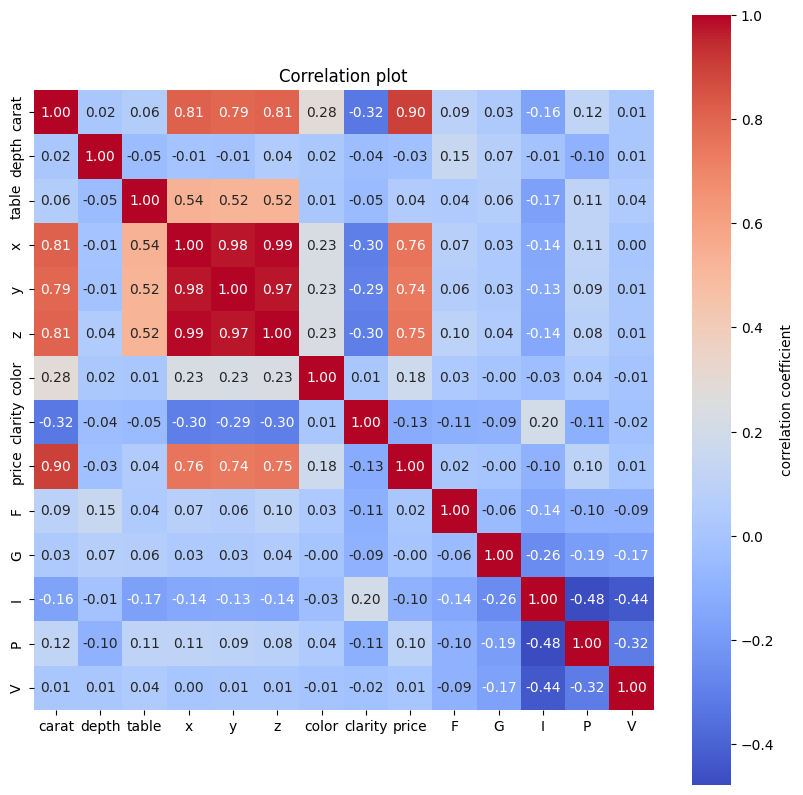

In [17]:
corr = train_XY.corr()

print(corr.round(2))

plt.figure(figsize = (10,10))
sns.heatmap(corr, annot = True, cmap = 'coolwarm',
            cbar_kws = {'label' : 'correlation coefficient'},
            square = True, fmt ='.2f')
plt.title('Correlation plot')

In [18]:
train_X, train_Y = train_XY.drop('price', axis=1), train_XY.price        # split into training I/O

<font color=green><h3><b>$\alpha$. Build polynomial features</b><h3>

In [19]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
tX = train_X#.iloc[:60000,:]   # subsample for experimentation
tY = train_Y#[:60000]   # subsample for experimentation



In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Scale features
scaler = StandardScaler()
trainX_scaled = scaler.fit_transform(train_X)
testX_scaled = scaler.transform(test_X)

trainY_scaled = (train_Y - train_Y.mean())/train_Y.std()
trainY_scaled.var()
#y_scaler = StandardScaler()
#tY0 = y_scaler.fit_transform(tY0)

0.9999999999999998

In [21]:
poly = PolynomialFeatures(degree=3)
trainX_poly = poly.fit_transform(trainX_scaled)
testX_poly = poly.transform(testX_scaled)

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import \
  cross_val_score, StratifiedKFold, GridSearchCV, TimeSeriesSplit, KFold, ShuffleSplit,\
  StratifiedKFold, GroupShuffleSplit, GroupKFold, StratifiedShuffleSplit

X_train, X_test, y_train, y_test = train_test_split(
    trainX_poly, trainY_scaled, test_size=0.2, random_state=42
)

param_grid = {
    "LinearRegression": {"fit_intercept": [True, False]},    
    "RidgeRegression": {
        "alpha": [1, 10, 100],
        "max_iter": [15000],
        "solver": [
            "auto",
            "lsqr",
        ]
    },
    "LassoRegression": {
        "alpha": [50, 100, 200],
        "max_iter": [15000],
        "warm_start": [True, False],
    },
    "ElasticNet": {
        "alpha": [10, 100],
        "l1_ratio": [0],
        "max_iter": [20000]
    },
}

models = {
    "LinearRegression": LinearRegression(),   
    #"RidgeRegression": Ridge(),
    #"LassoRegression": Lasso(),
    #"ElasticNet": ElasticNet(),
}

for name, model in models.items():
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid[name], cv=10, verbose=3)
    grid_search.fit(X_train, y_train)

    print(f"\nBest parameters for {name}:")
    print(grid_search.best_params_)

    # Predict with best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    results = {}
    print(f"Score for {name} with best parameters:")
    for metric in [r2_score, mean_absolute_error]:
        score = metric(y_test, y_pred)
        print(f"{metric.__name__}: {score:.4f}")

        if metric not in results:
            results[metric] = {}
        results[metric][f"{name}_best"] = score


Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 1/10] END ...............fit_intercept=True;, score=0.945 total time=  32.2s
[CV 2/10] END ...............fit_intercept=True;, score=0.942 total time=  12.8s
[CV 3/10] END ...............fit_intercept=True;, score=0.933 total time=   9.2s
[CV 4/10] END ...............fit_intercept=True;, score=0.939 total time=   7.6s
[CV 5/10] END ...............fit_intercept=True;, score=0.943 total time=   7.6s
[CV 6/10] END ...............fit_intercept=True;, score=0.914 total time=   7.9s
[CV 7/10] END ...............fit_intercept=True;, score=0.945 total time=   7.6s
[CV 8/10] END ...............fit_intercept=True;, score=0.943 total time=   7.4s
[CV 9/10] END ..............fit_intercept=True;, score=-3.719 total time=   7.7s
[CV 10/10] END ..............fit_intercept=True;, score=0.941 total time=   7.5s
[CV 1/10] END ..............fit_intercept=False;, score=0.945 total time=   7.5s
[CV 2/10] END ..............fit_intercept=False;

GridSearchCV(cv=10, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]}, verbose=3)


Best parameters for LinearRegression:
{'fit_intercept': True}
Score for LinearRegression with best parameters:
r2_score: 0.9406
mean_absolute_error: 0.1414


In [23]:
#best_model.fit(trainX_poly, trainY_scaled)

<font color=green><h3><b>$\beta$. Fit the model to the training dataset</b><h3>

In [24]:
m = LinearRegression()
m.fit(trainX_poly, trainY_scaled)

LinearRegression()

In [25]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import StratifiedKFold
# creating CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [26]:
#rr = Ridge(alpha=1, max_iter=15000, solver='svd')
#rr.fit(tX0_in, tY)


<font color=green><h3><b>$\gamma$. Generate and post-process predictions.</font>

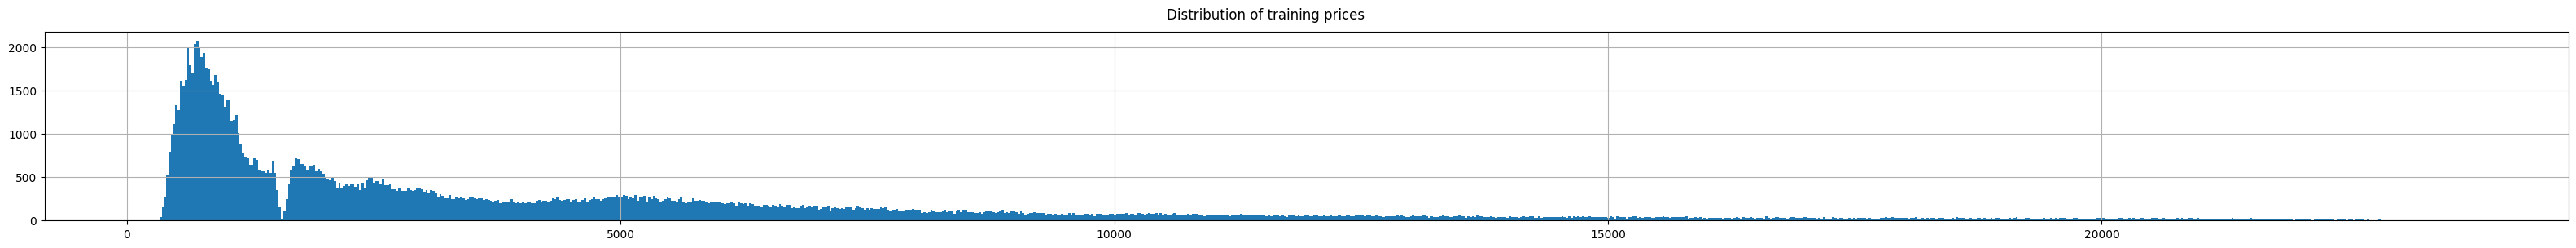

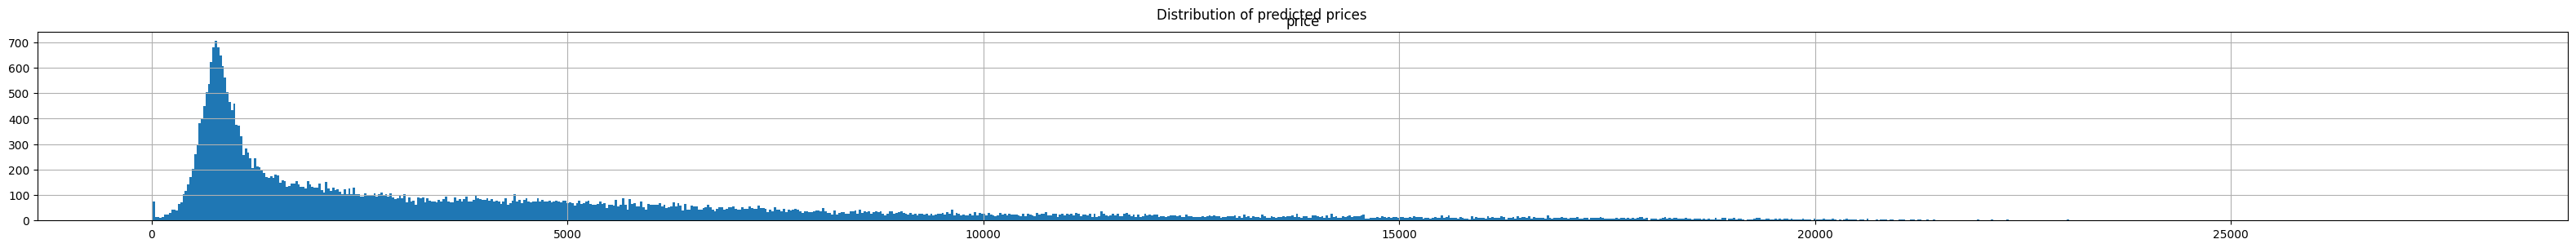

In [27]:
pY = pd.DataFrame(m.predict(testX_poly), index=range(1,len(testX_poly)+1), columns=['price'])  # ensure that labels and observations are in corresponding order
pY = pY * train_Y.std() + train_Y.mean()
pY = pY.clip(lower=10)  # ensures no negative prices
_ = tY.hist(figsize=(40,3), bins=1000);  _ = plt.suptitle("Distribution of training prices");
_ = pY.hist(figsize=(40,3), bins=1000);  _ = plt.suptitle("Distribution of predicted prices");
ToCSV(pY, 'Pred_LR')

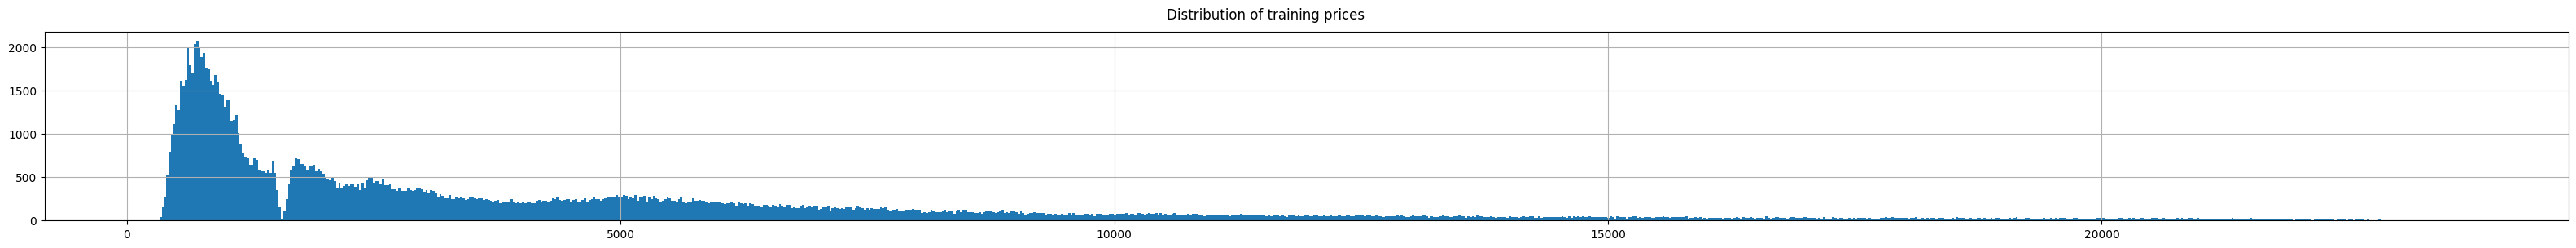

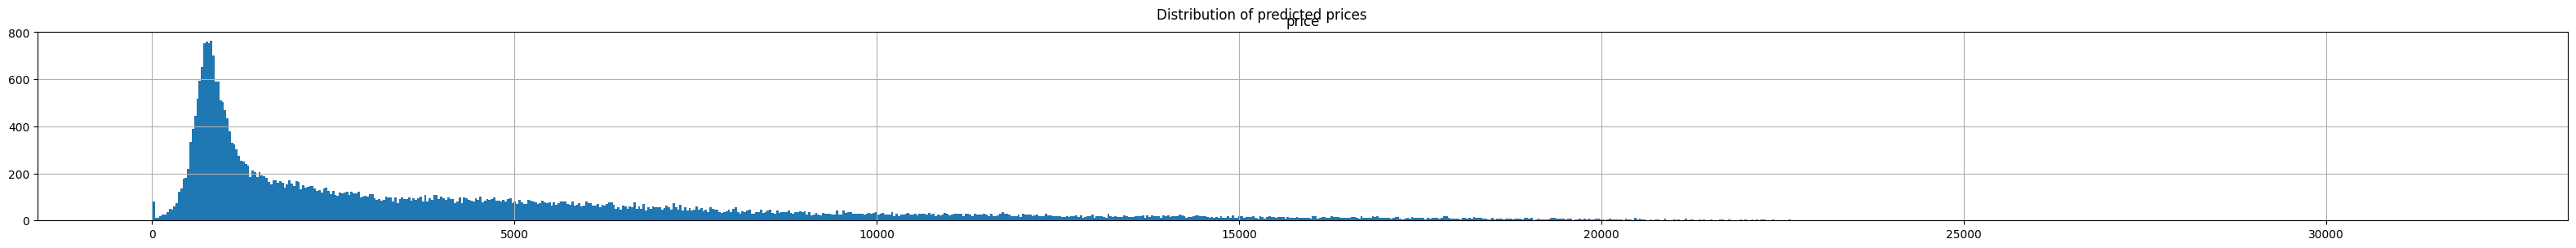

In [28]:
pY = pd.DataFrame(best_model.predict(testX_poly), index=range(1,len(testX_poly)+1), columns=['price'])  # ensure that labels and observations are in corresponding order
pY = pY * train_Y.std() + train_Y.mean()
pY = pY.clip(lower=10)  # ensures no negative prices
_ = tY.hist(figsize=(40,3), bins=1000);  _ = plt.suptitle("Distribution of training prices");
_ = pY.hist(figsize=(40,3), bins=1000);  _ = plt.suptitle("Distribution of predicted prices");
ToCSV(pY, 'Best_pred')

<font color=green><h3><b>$\epsilon$. Documentation</b></h3></font>

<font color=green><h4><b>Task 1. Explain Decisions in Preprocessing Pipeline</b></h4></font>

<font color=green>
Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.</font>

<font color=green>

1. Why did you choose these elements? (Something in EDA, prior experience,...? Note: EDA is not required)
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

<font color=red><b>Your answer here.</b></font>

<font color=green><h4><b>Task 2. Explain Decisions in Modeling Pipeline</b></h4></font>

<font color=green>
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful.

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

<font color=red><b>Your answer here.</b></font>

<font color=green><h3><b>$\zeta$. References</b></h3></font>

<font color=red><b>Your answer here.</b></font>

<font color=green>
Cite your sources to help your peers learn from these (and to avoid plagiarism claims). At the least, ISLP textbook should be cited. Use Google Scholar to draw APA citation format for books and publications. Also cite StackOverflow, package documentation, and other meaningful internet resources.

1. ...
1. ...

<font size=5>⌛</font> <strong><font color=green size=5>Do not exceed competition's runtime limit! Do not write code outside TGP</font></strong>
<hr color=green size=40>

In [29]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 234 sec > 60 sec limit!!!


## 💡**Starter Ideas**

1. Tune model hyperparameters
1. Try to linear and non-linear feature normalization: shift/scale, log, divide features by features (investigate scatterplot matrix)
1. Try higher order feature interactions ($x_i^a$, $x_ix_j$, ...) to identify new key features or their linear combinations. With too many features you can use a smaller subsample or reduce dimensionality of feature space using [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), [tSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), or [UMAP](https://umap-learn.readthedocs.io/en/latest/).
1. Do a thorough EDA and understand non-linear relation in I/O. Are any interactions more special than others (E.g. is diamond *volume* a better predictor?)
1. If you note a shift in trend for any predictors, try building a model for each trend.
1. Evaluate predictions and focus on poorly predicted "groups". Can they be identified and modeled separately?
1. Do scatter plots show piecewise linear shape? Can a separate linear model be used on each support of approximately linear X-Y relation?
1. How are categorical features treated by the SKLearn models? Is there a [better way](https://www.google.com/search?q=ways+to+encode+categorical+data) to encode these (perhaps, ordinal) features?
  1. E.g. you could replace codes (or groups of codes) with their frequencies, which may capture the implied "distance" or rarity between category levels.
  1. If encoding ordinal features with integers, should non-equidistant values be considered?
1. Learn about [modeling price of a diamond](https://www.google.com/search?q=machine+learning+model+price+diamond).
1. Try post-processing: shifting/scaling/transforming the distribution of predicted prices `pY` to match the distribution of training prices `tY`
